## Dataset and Problem Introduction

In this analysis, we explore ["SAT"-exams](https://en.wikipedia.org/wiki/SAT) and what factors drive differences in exam scores.

Data Sources:
+ [SAT scores by school - SAT scores for each high school in New York City](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4)
+ [School attendance - Attendance information for each school in New York City](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt)
+ [Class size - Information on class size for each school](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)
+ [AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e)
+ [Graduation outcomes - The percentage of students who graduated, and other outcome information](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a)
+ [Demographics - Demographic information for each school](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j)
+ [School survey - Surveys of parents, teachers, and students at each school](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8)

<br>Reference: https://dataquest.io/

## Reading in data

In [1]:
# standard libs from dq and additional utilities (PEP-8 made me do it in this order)
from tqdm.notebook import tqdm_notebook # progress bar for timeconsuming geocoding
import tqdm
import warnings  # used here to surpress FutureWarning
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
import seaborn as sns

# additional libs used for this projects
from sodapy import Socrata  # api calls
import geopy  # reverse geocoding
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import plotly as py  # interactive plotting
import plotly.graph_objs as go
import cufflinks as cf  # interactive plotting made easy (pandas style)

# Using plotly + cufflinks in offline mode
from plotly.offline import iplot, init_notebook_mode
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

# jupyter command to show plots in notebook
%matplotlib inline

# setting pandas display options
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option("display.max_columns", 20)
#pd.set_option("display.max_rows", 20)
pd.set_option('max_colwidth', 50)


# read seperate input files into single dictionary
# csv-files
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("datasets/{0}".format(f))
    data[f.replace(".csv", "")] = d

# survey data, different format
all_survey = pd.read_csv("datasets/survey_all.txt",
                         delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("datasets/survey_d75.txt",
                         delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN",
    "rr_s",
    "rr_t",
    "rr_p",
    "N_s",
    "N_t",
    "N_p",
    "saf_p_11",
    "com_p_11",
    "eng_p_11",
    "aca_p_11",
    "saf_t_11",
    "com_t_11",
    "eng_t_11",
    "aca_t_11",
    "saf_s_11",
    "com_s_11",
    "eng_s_11",
    "aca_s_11",
    "saf_tot_11",
    "com_tot_11",
    "eng_tot_11",
    "aca_tot_11",
]
survey = survey.loc[:, survey_fields]
data["survey"] = survey

## Adding and converting features

In [2]:
# add DBN columns as unique identifier in datasets where they are not yet present
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

data["class_size"]["padded_csd"] = data["class_size"]["CSD"].astype(str).str.pad(2,fillchar="0")
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# summing SAT-score
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# extracting latitude and longitude to separate columns
pattern = r"\((.+),(.+)\)"
data["hs_directory"][["lat","lon"]] = data["hs_directory"]["Location 1"].str.extract(pattern).astype(float)

# convert AP scores to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Condensing and combining datasets

In [3]:
# selecting the classes relevant for SAT-analysis (high school, general education)
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

# compute average class size by school across all subjects
data["class_size"] = pd.pivot_table(class_size, values="AVERAGE CLASS SIZE", index="DBN").reset_index()

# select most recent data available in "demographics" and "graduation" dataset
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# initiate combined dataset with our main variable we want to investigate
combined = data["sat_results"]

# left joins for somewhat sparse datasets, because we do not want to loose any SAT-info
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

# inner joins for other dataset that potentially contain very relevant explanatory features.
# if these features are not available for a high school, our we want to exclude these schools
to_merge = ["class_size", "demographics", "survey", "hs_directory"]
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

# missing values for numeric columns filled with mean, non-numerics with zeros 
combined = combined.fillna(combined.mean()) # potential lever to improve quality of analysis, not scope of this learning exercise
combined = combined.fillna(0)

# Add a school district column for later analysis
combined["school_dist"] = combined["DBN"].str[:2]

## Survey results: Safety and student expectations are important

In [4]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

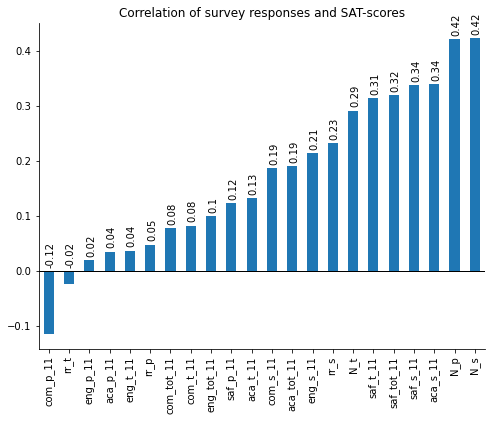

In [5]:
# compute all correlations with SAT scores
correlations = combined.corr()["sat_score"]

# build a barchart to visualize SAT and survey response correlation  
ax = correlations[survey_fields].sort_values().plot(kind="bar",
                                                    figsize=(8, 6),
                                                    title="Correlation of survey responses and SAT-scores")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)),
                (p.get_x()+0.1, max(p.get_height(), 0)+0.01),
                rotation=90
                )
ax.axhline(y=0.0, color='black', linestyle='-', linewidth=1)
plt.show()

Safety / Respect ("saf_...") and student academic expectations ("aca_s_11") are correlated with good SAT scores. <br> This intuitively makes sense - if students feel safe and have trust in themselves / sets higher expectations, they (can) focus on achieving good academic results.  

Additional details: 
* aca_...: Academic expectations score is based on student (s), teacher (t) and parent (p) responses: Interesting to see that aca_p and aca_t (teachers) exhibit a lower correlation than expectation set by students.
* saf_t_11, Safety and Respect score is based on teacher responses: Teachers perceived safety and respect score seems relevant.

## Crime: Missing safety  in the Bronx and Brooklyn impedes high SAT-scores 

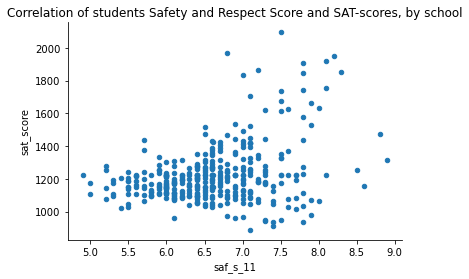

In [6]:
# build a scatter plot to visualize correlation between SAT and Safety and Respect Rating (students)
ax = combined.plot(kind="scatter", x="saf_s_11", y="sat_score",
                   figsize=(6, 4),
                   title="Correlation of students Safety and Respect Score and SAT-scores, by school")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

Beyond a certain threshold of safety-rating (~6.5), there are no schools with high SAT-ratings. This looks like unsafe environments prohibit higher scores.

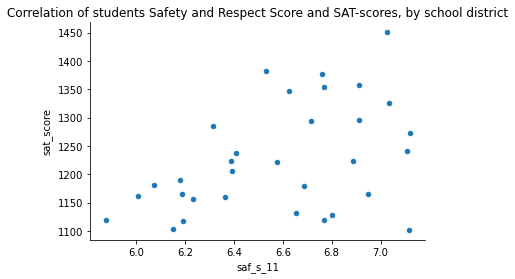

In [7]:
# build second scatter plot to visualize correlation between SAT and Safety and Respect Rating (students)
by_district = combined.groupby("school_dist").mean().reset_index()

ax = by_district.plot(kind="scatter", x="saf_s_11", y="sat_score",
                      figsize=(6, 4),
                      title="Correlation of students Safety and Respect Score and SAT-scores, by school district")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

The relationship is also visible on an aggregate level - but with a higher spread of the SAT scores as the Safety / Respect Score increases. Again, this could be an indication that safety is a necessary but not a sufficient factor for high SAT scores.

In [8]:
# code for map
import folium
import branca.colormap as cm

# set a simple baselayer and zoom-in on NY
school_map = folium.Map(location=[40.693943, -73.985880], 
                        #width=500,
                        #height=800,
                        zoom_start=10,
                        tiles='CartoDB positron')

# generate a title above the map
# from https://github.com/python-visualization/folium/issues/1202
map_title = "NY highschools: Safety / Respect Score and avg. enrollment by school district"
title_html = '''
             <h3 align="center" style="font-size:20px"><b>{}</b></h3>
             '''.format(map_title)
school_map.get_root().html.add_child(folium.Element(title_html))

# select column names of the viz parameters
size_parameter = "total_enrollment"
color_parameter = "saf_s_11"

# generate a colormap to shade the cirles on the map
# from https://stackoverflow.com/questions/56876620/unsure-how-to-use-colormap-with-folium-marker-plot
start_col_val = by_district[color_parameter].min()
end_col_val = by_district[color_parameter].max()
start_col_hex = "#d01c8b" # used https://colorbrewer2.org/ 
end_col_hex = "#4dac26"
colormap = cm.LinearColormap(colors=[start_col_hex,
                                     #"white",
                                     end_col_hex],
                             vmin=start_col_val,
                             vmax=end_col_val
                            )
colormap.caption = "Safety / Respect Score, students response"

# create a circle for each school district
for index, row in by_district.iterrows():
    folium.Circle(location=[row["lat"],row["lon"]],
                  color=colormap(row[color_parameter]),
                  fill_color=colormap(row[color_parameter]),
                  fill_opacity=0.75,
                  radius=row[size_parameter],
                  weight=2,
                  tooltip="District "+row["school_dist"]+
                      " <br> Avg. Safety / Respect Score, students response (color): {:.1f}".format(row[color_parameter])+
                      " <br> Avg. enrollment per school (size): {:.0f}".format(row[size_parameter])
                 ).add_to(school_map)

# add a legend
school_map.add_child(colormap)
    
# display the map
print("Interactive Map - NY highschools: Safety / Respect Score and avg. enrollment by school district")
school_map

Interactive Map - NY highschools: Safety / Respect Score and avg. enrollment by school district


Students in Northern Brooklyn and parts of the Bronx particularly report below average Safety / Respect Scores.
This somewhat aligns with a [*New York Times* article](https://archive.nytimes.com/www.nytimes.com/interactive/2010/07/11/nyregion/20100711-stop-and-frisk.html) from around that time - the piece reports that precincts with the highest crime rates are in these areas.<br>

## Race: Hispanic and African American disadvantages

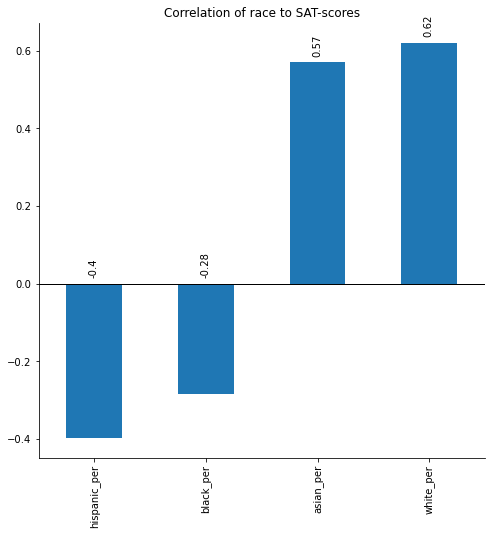

In [9]:
# build scatter plot to visualize correlation between SAT and race of students
race_field = ["asian_per","black_per","hispanic_per","white_per"]

ax = correlations[race_field].sort_values().plot(kind="bar",
                                                    figsize=(8, 8),
                                                    title="Correlation of race to SAT-scores")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for p in ax.patches: # set data point labels
    ax.annotate(str(round(p.get_height(), 2)),
                (p.get_x() + 0.2, max(p.get_height(), 0)+0.02),
                rotation=90
                )
ax.axhline(y=0.0, color='black', linestyle='-', linewidth=1)
plt.show()

+ Achievement gaps in the US are well documented [(example1](https://nces.ed.gov/nationsreportcard/studies/gaps/), [example2](https://cepa.stanford.edu/educational-opportunity-monitoring-project/achievement-gaps/race/) - both are from the same time period as our data). The general trends of Hispanics and African Americans scoring lower than Asians and whites also persists in this NYC dataset. <br> The negative correlation is higher for Hispanics (about -0.4) than for African Americans (about -0.3). Examples 1 and 2 above showed higher achievement gaps for African Americans than for Hispanics -  data cited on [wikipedia](https://en.wikipedia.org/wiki/Racial_achievement_gap_in_the_United_States) is however  consistent with our NYC data. 
+ A slightly higher positive correlation for whites compared to Asians was a bit surprising. It is commonly reported the other way around.

In [10]:
print('Interactive Map - Share of hispanic students vs. SAT score by school')
with warnings.catch_warnings(): # to catch warning about np.module in Python 3.8.2.
    warnings.filterwarnings("ignore",category=FutureWarning)
    combined.iplot(
        x='hispanic_per',
        y='sat_score',
        categories='boro',
        text="SCHOOL NAME",
        vline= {"x":combined["hispanic_per"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":combined["sat_score"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='Share hispanics, %',
        yTitle='Avg. SAT score',
        title='Share of hispanic students vs. SAT score by school <br> dashed lines: average of entire dataset'
    )

Interactive Map - Share of hispanic students vs. SAT score by school


* Almost all schools in the Bronx exhibit above average high shares of Hispanics and below average SAT scores. There might be confounding factors (crime or poverty) leading to low SAT scores of Hispanics in NYC.

* Schools with very low average SAT scores and very high shares of Hispanic students are specialized on students with limited English skills (often named "International" schools etc.). It is not surprising that these schools score below average, because SAT tests both reading and writing.

* The schools with high SAT scores and low shares of Hispanics are all highly selective public schools with excellent reputations.

In [11]:
print('Interactive Map: Racial distribution NYC high schools')
# build stacked bar to racial makeup of all schools and elite schools
num_race = ['asian_num', 'black_num', 'hispanic_num', 'white_num']
high_sat = combined["sat_score"] > 1800

race_dist = pd.DataFrame(data=[combined.loc[:, num_race].sum()/combined.loc[:, num_race].sum().sum(),
                               combined.loc[high_sat, num_race].sum()/combined.loc[high_sat, num_race].sum().sum()],
                         index=["All schools", "Elite schools"])*100
race_dist.columns = ["Asian","Black","Hispanic", "White"]
race_dist.astype(int).iplot(kind="bar", barmode="stack", yTitle='Share of all students in %',
                            title='Racial distribution NYC high schools, <br> all vs. elite (SAT avg. > 1,800)')

Interactive Map: Racial distribution NYC high schools


African Americans and Hispanics are clearly underrepresented in NYC's elite high schools - white and especially Asian students are overrepresented compared to all NYC high schools. This is the case although there are elite schools in all five boroughs.

## Gender: Males over-represented in STEM-elite schools, Queens and Manhattan with excellent predominantly female schools 

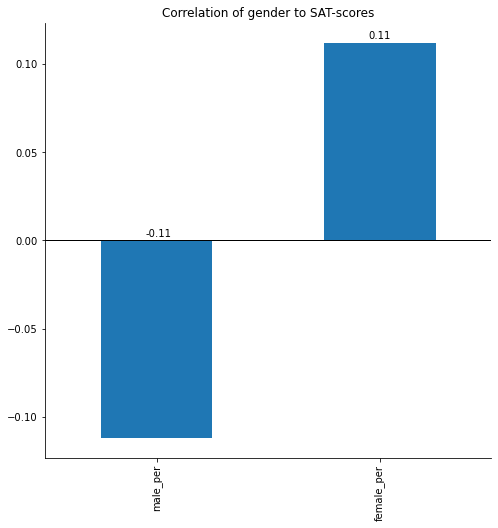

In [12]:
# build bar chart to visualize correlation between SAT and gender of students
gender = ["male_per", "female_per"]

ax = correlations[gender].sort_values().plot(kind="bar",
                                                    figsize=(8, 8),
                                                    title="Correlation of gender to SAT-scores")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for p in ax.patches: # set data point labels
    ax.annotate(str(round(p.get_height(), 2)),
                (p.get_x() + 0.2, max(p.get_height(), 0)+0.002),
                rotation=0
                )
ax.axhline(y=0.0, color='black', linestyle='-', linewidth=1)
plt.show()

Schools exhibit higher SAT-scores when the share of females is higher, but the correlation is pretty weak (~ 0.1).

In [13]:
print('Interactive Map - Share of female students vs. SAT score by school')
with warnings.catch_warnings(): # to catch FutureWarning about np.module being used in pandas
    warnings.filterwarnings("ignore",category=FutureWarning)
    combined.iplot(
        x='female_per',
        y='sat_score',
        categories='boro',
        text="SCHOOL NAME",
        vline= {"x":combined["female_per"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":combined["sat_score"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='Share females, %',
        yTitle='Avg. SAT score',
        title='Share of female students vs. SAT score by school <br> dashed lines: average of entire dataset'
    )

Interactive Map - Share of female students vs. SAT score by school


+ All eleven schools with an above 60% share of females and SAT-scores above 1,400 are located in Manhattan and Queens. Girls in other boroughs may have poorer access to excellent education.
+ The high performing / mainly female schools are mostly humanities / arts focused. 
+ Seven of the nine previously defined "elite schools" with average SAT scores above 1,800 are majority male - they are STEM focused.

## Function to assist with analysis

In [14]:
# built function "describe_plus" to help with investigation of subsets
# helper functions


def describe_nan(df):
    """
    Return transposed pandas describe with share of nan-values

    Parameters:
    df = pandas.DataFrame
    """
    df_des = df.describe().transpose()
    df_des["share_nan"] = 1-(df_des["count"]/df.shape[0])
    df_des_col_order = ["share_nan", "count", "mean",
                        "std", "min", "25%", "50%", "75%", "max"]
    df_des = df_des[df_des_col_order]
    return df_des


def describe_frequent(df, n=5):
    """
    Returns dataframe with most common values

    Parameters:
    df = pandas.DataFrame
    n = Optional number of most common values 

    """
    topn_df = pd.DataFrame()
    col_names = df.columns

    for col in col_names:
        col_name = df[col].name
        top_n = df[col].value_counts(dropna=False)[
            :n].reset_index().reset_index()
        top_n_norm = df[col].value_counts(dropna=False, normalize=True)[
            :n].reset_index().reset_index()
        top_n["norm"] = (top_n_norm[col_name]*100).astype(int)
        top_n["level_0"] = top_n["level_0"]+1
        top_n["string"] = "value: "+top_n["index"].astype(
            str)+" | count: "+top_n[col_name].astype(str)+" | norm %: "+top_n["norm"].astype(str)
        result = top_n["string"]
        result.rename(col_name, inplace=True)
        topn_df = pd.concat([topn_df, result], axis=1)
    topn_df.index = "Top"+(topn_df.index + 1).astype(str)
    return topn_df

# main function


def describe_plus(df, subset=None, output=None,
                  figsize=(15, 20), cmap="RdBu"):
    '''
    Returns a dataframe of descripitive strings.
    If only a dataframe is passed, pandas 'describe'-method includes missing value count in %. 
    If also one subset is passed, the resulting subset is compared to the entire dataset.

    Parameters:
    df: Required pandas.DataFrame
    subset: Optional pandas.DataFrame with identical columns to compare to df
    output: Optional, if only one df is passed, "non_num" returns df with all 
            non numeric columns and adds descriptive stats as first rows.
            If subset is passed, "clean" returns a DataFrame without styling.
            If subset is passed, "sorted" returns a styled DataFrame, 
            sorted by z-score. 
    cmap: Optional parameter, default colormap "RdBu"

    Returns:
    (styled) pandas.Dataframe
    '''

    if subset is None:
        if output == "non_num":
            # get only the numeric columns from the dataframe
            all_cols = df.columns
            # describe only works on numerical columns
            num_cols = describe_nan(df).index
            non_num_cols = [col for col in all_cols if col not in num_cols]
            df_non_num = df[non_num_cols]

            # calc some stats on non-numeric columns
            df_stats = pd.DataFrame(columns=non_num_cols)
            df_stats.loc["Record count"] = df_non_num.shape[0]
            df_stats.loc["Count Nan"] = df_non_num.isna().sum()
            df_stats.loc["Share Nan"] = df_non_num.isna().sum() / \
                df_non_num.shape[0]
            df_stats.loc["Count unique"] = df_non_num.nunique()

            # add most common values
            df_stats = pd.concat([df_stats, describe_frequent(df_non_num)])

            # prepend stats to df
            df_non_num_up = pd.concat([df_stats, df_non_num])

            return df_non_num_up

        else:
            return describe_nan(df).style.background_gradient(subset="share_nan", low=0, high=1, cmap="Blues")

    else:
        # calculate descriptive stats
        subset_desc = describe_nan(subset)
        df_desc = describe_nan(df)

        # calculate percent change (used to be for sns.heatmap)
        hm_data = (subset_desc/df_desc)
        hm_data["z-score, subset mean"] = (subset_desc["mean"] -
                                           df_desc["mean"])/(df_desc["std"])
        hm_data["count"] = 0  # no color for count
        hm_data = hm_data[['count', "share_nan", 'z-score, subset mean',
                           'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

        # format main annotation values
        main_values = pd.DataFrame()
        main_values = pd.concat(
            [main_values, subset_desc.loc[:, "mean":"max"]], axis=1)
        main_values = main_values.applymap('{:,.2f}'.format)
        main_values["z-score, subset mean"] = (
            subset_desc["mean"]-df_desc["mean"])/(df_desc["std"])
        main_values["count"] = subset_desc['count'].apply('{:,.0f}'.format)
        main_values["share_nan"] = (
            subset_desc['share_nan']*100).apply('{:,.0f}%'.format)
        main_values = main_values[[
            'count', "share_nan", 'z-score, subset mean', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

        # values of subset are compared to main dataset in annotation as follows:
        # count (share of total records)
        # share_Nan (% compared to entire dataset)
        # mean (% compared to entire dataset)
        # z-score of subset-mean (no comparison)
        # std (% compared to entire dataset)
        # min,25%,50%,75%,max (percentile rank of entire dataset)
        # dataframe has same columns, but z-score is also seperate and shaded
        # percentages are formatted as integer with sign

        # pct rank: copy output from description method to original dataframe
        subset_desc_pct_rank = pd.concat(
            [df, subset_desc.loc[:, "min":"max"].transpose()]).dropna(axis=1, subset=["min"])

        # pct rank: make a column with percentile rank for every numeric column
        list_col_pct = []
        for col in subset_desc_pct_rank:
            col_pct = col+"_pct_rank"
            list_col_pct.append(col_pct)
            subset_desc_pct_rank[col_pct] = subset_desc_pct_rank[col].rank(
                pct=True)

        # pct rank: discard main dataset, apply proper names and shape
        subset_desc_pct_rank = (
            subset_desc_pct_rank.loc["min":"max", list_col_pct].transpose()*100).astype(int)
        subset_desc_pct_rank.index = subset_desc_pct_rank.index.str.replace(
            "_pct_rank", "")
        subset_desc_pct_rank.columns = subset_desc_pct_rank.columns+"_pct_rank"

        # format all values going into parenthesis
        paran = pd.DataFrame()
        paran["count"] = ((subset_desc/df_desc)["count"]
                          * 100).apply('{:,.0f}%'.format)
        paran["share_nan"] = hm_data["share_nan"].apply('{:,.0f}%'.format)
        paran["z-score, subset mean"] = "-"
        paran["mean"] = ((((subset_desc/df_desc)["mean"])-1)
                         * 100).apply('{:+,.0f}%'.format)
        paran["std"] = ((((subset_desc/df_desc)["std"])-1)
                        * 100).apply('{:+,.0f}%'.format)
        paran = pd.concat([paran, subset_desc_pct_rank], axis=1)
        paran.columns = paran.columns.str.replace("_pct_rank", "")

        # build the annotation
        annot = main_values.astype(str)+" ("+paran.astype(str)+")"
        annot["z-score, subset mean"] = main_values["z-score, subset mean"]

        # decided to redo column headers
        new_col_headers = {'count': "count (share of df)",
                           "share_nan": "share_nan (change to df)",
                           'z-score, subset mean': "z-score, subset mean",
                           'mean': " mean (change to df)",
                           'std': "std (change to df)",
                           'min': "min (pct rank in df)",
                           '25%': "25% (pct rank in df)",
                           '50%': "50% (pct rank in df)",
                           '75%': "75% (pct rank in df)",
                           'max': "max (pct rank in df)"
                           }
        annot.rename(inplace=True, columns=new_col_headers)

        if output == "clean":
            return annot

        elif output == "sorted":
            return annot.sort_values(by="z-score, subset mean").style.background_gradient(
                subset="z-score, subset mean", cmap="RdBu")

        else:
            return annot.style.background_gradient(
                subset="z-score, subset mean", cmap="RdBu")

## Advanced placement:  Not always a good preparation for SAT

In [15]:
# compute new feature: share of students that took Advanced Placement (AP) exams to earn college credit
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]*100

In [16]:
print('Interactive Map - Share of AP-Test takers vs. SAT score by school')
# build scatter plot investigating correlation between share of AP-Test takers and SAT-score
with warnings.catch_warnings(): # to catch FutureWarning about np.module being used in pandas
    warnings.filterwarnings("ignore",category=FutureWarning)
    combined.iplot(
        x='ap_per',
        y='sat_score',
        categories='boro',
        text="SCHOOL NAME",
        vline= {"x":combined["ap_per"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":combined["sat_score"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='AP-Test Takers, %',
        yTitle='Avg. SAT score',
        title='Share of AP-Test takers vs. SAT score by school <br> dashed lines: average of entire dataset'
    )

Interactive Map - Share of AP-Test takers vs. SAT score by school


Advanced Placement (AP) is a program in the United States and Canada created by the College Board which offers college-level curricula and examinations to high school students.

We see three interesting patterns in the data:
+ **SAT above 1,400**: Amongst schools with high SAT-scores (above 1,400) there seems to be a strong correlation between the share of AP-test takers and SAT-Scores.
+ **SAT below 1,300 and above average share of AP-test takers**: These are schools that might score lower on SATs because they cater to otherwise disadvantaged students (more free lunches, more special education) and are more focused on generally disadvantaged parts of New York’s population (Hispanics / African Americans). The AP courses they offer are less diverse and mainly focused on English literature and language - it is surprising, that these schools nonetheless score low on SAT's reading and writing sections.  
+ **Average SAT and very high shares of AP-test takers**: Since almost all these schools have SAT score that are equal to the average of the dataset, I suspect that their SAT score was missing and imputed.

Overall, it looks like the share of AP-test takers is not a strong indicator for SAT-performance.

In [17]:
# select only schools with high (but not extremely high) shares of AP test takers and low SAT scores
high_ap_low_sat = combined[(combined["ap_per"]>25)&
                           (combined["ap_per"]<50)&
                           (combined["sat_score"]<1300)]
describe_plus(combined,subset=high_ap_low_sat,output="sorted")

,count (share of df),share_nan (change to df),"z-score, subset mean",mean (change to df),std (change to df),min (pct rank in df),25% (pct rank in df),50% (pct rank in df),75% (pct rank in df),max (pct rank in df)
AVERAGE CLASS SIZE,105 (29%),0% (nan%),-0.560828,22.80 (-8%),3.40 (-5%),10.00 (0),20.83 (11),23.17 (32),25.14 (53),30.94 (96)
SAT Math Avg. Score,105 (29%),0% (nan%),-0.525060,385.63 (-8%),29.36 (-55%),312.00 (0),367.00 (15),385.00 (33),411.00 (52),441.00 (76)
sat_score,105 (29%),0% (nan%),-0.513529,"1,131.92 (-7%)",80.00 (-55%),913.00 (0),"1,080.00 (13)","1,143.00 (33)","1,199.00 (52)","1,273.00 (77)"
SAT Critical Reading Avg. Score,105 (29%),0% (nan%),-0.510077,374.80 (-7%),29.49 (-49%),287.00 (0),360.00 (13),381.00 (32),400.00 (53),418.00 (75)
SAT Writing Avg. Score,105 (29%),0% (nan%),-0.476021,371.49 (-7%),26.97 (-54%),291.00 (0),357.00 (15),377.00 (36),394.00 (55),414.00 (76)
N_s,105 (29%),0% (nan%),-0.459995,291.04 (-51%),81.18 (-88%),93.00 (2),240.00 (17),300.00 (29),340.00 (42),598.21 (78)
total_enrollment,105 (29%),0% (nan%),-0.458799,396.04 (-50%),64.15 (-93%),141.00 (0),356.00 (17),401.00 (28),445.00 (44),500.00 (58)
total_students,105 (29%),0% (nan%),-0.451494,409.50 (-47%),85.48 (-90%),110.00 (0),351.00 (18),412.00 (30),466.00 (47),664.00 (76)
male_num,105 (29%),0% (nan%),-0.448658,189.65 (-53%),64.14 (-86%),0.00 (1),159.00 (18),195.00 (33),225.00 (47),402.00 (78)
female_num,105 (29%),0% (nan%),-0.437781,206.38 (-47%),73.66 (-83%),61.00 (1),163.00 (17),196.00 (31),239.00 (47),495.00 (83)


The schools with above average shares of AP-test takers and low SAT scores achieve poor results across all three parts of the SAT (negative z-score) - writing being least below average.

Other noteworthy characteristics these schools have compared to NYC averages are:
+ Smaller class sizes and smaller schools (total_enrollment)
+ Higher shares of students receiving free lunch (frl_per)
+ Higher share of special education students (sped_per)
+ Higher shares of Hispanic and especially African American students (black_per, hispanic_per)

In [18]:
# investigating non-numeric features
pd.set_option("display.max_rows", 95)
describe_plus(high_ap_low_sat,output="non_num")[:9].transpose().head()

,Record count,Count Nan,Share Nan,Count unique,Top1,Top2,Top3,Top4,Top5
DBN,105,0,0.000,105,value: 09X252 | count: 1 | norm %: 0,value: 05M362 | count: 1 | norm %: 0,value: 02M392 | count: 1 | norm %: 0,value: 17K546 | count: 1 | norm %: 0,value: 18K563 | count: 1 | norm %: 0
SCHOOL NAME,105,0,0.000,105,value: THE URBAN ASSEMBLY SCHOOL FOR GREEN CAR...,value: ARTS & MEDIA PREPARATORY ACADEMY | coun...,"value: HERITAGE SCHOOL, THE | count: 1 | norm ...",value: ACADEMY OF HOSPITALITY AND TOURISM | co...,value: HIGH SCHOOL OF WORLD CULTURES | count: ...
Num of SAT Test Takers,105,0,0.000,51,value: s | count: 14 | norm %: 13,value: 54 | count: 4 | norm %: 3,value: 61 | count: 4 | norm %: 3,value: 69 | count: 3 | norm %: 2,value: 49 | count: 3 | norm %: 2
SchoolName,105,0,0.000,16,value: 0 | count: 90 | norm %: 85,value: PARK EAST H.S. | count: 1 | norm %: 0,value: High School for Public Service: Heroes ...,value: Performing Arts and Technology High Sch...,value: Lower Manhattan Arts Academy | count: 1...
Demographic,105,0,0.000,2,value: Total Cohort | count: 82 | norm %: 78,value: 0 | count: 23 | norm %: 21,NaN,NaN,NaN


For the subset with low average SAT scores but above AP-shares, "advancedplacement_courses" are very often "English Literature..." or "English Language and Composition". <br>

In [19]:
print('Interactive Map - AP classes by school types')
# extract and display list of most common AP-coures and plot how often they appear 
# first select other schools for comparison:
high_ap_high_sat = combined[(combined["ap_per"]>25)&
                            (combined["ap_per"]<50)&
                            (combined["sat_score"]>1300)]

# define loop trough subsets and extract relative distribution of ap_courses
subsets = {"High AP, low SAT": high_ap_low_sat,
           "High AP, high SAT": high_ap_high_sat}
subsets_ap_courses = pd.DataFrame()

for k, v in subsets.items():
    ap_courses = v["advancedplacement_courses"].str.split(",",expand=True)
    ap_courses_melted = ap_courses.melt()["value"].str.strip().value_counts(normalize=True).sort_values()
    ap_courses_melted.name = k
    subsets_ap_courses = pd.concat([subsets_ap_courses, ap_courses_melted], axis=1)

ax = (subsets_ap_courses*100).iplot(kind="bar", 
                            #figsize=(10,7), 
                            layout = dict(title="AP classes by school types, normalized count in %",
                                          xaxis=dict(automargin=True), hovermode="x", height=600))

Interactive Map - AP classes by school types


Schools with high shares of students taking AP-tests offer a narrower range of courses with a focus on history, English literature / language / composition. 
Calculus is offered, but almost only AB while the broader BC is less covered [(info)](https://blog.prepscholar.com/should-i-take-ap-calculus-ab-or-ap-calculus-bc).

## Conclusions
+ Consistent with serious research, Hispanic and African American students are at a disadvantage. They are schooled in less safe neighbourhoods and less often admitted to their borough's elite high-schools.
+ STEM-focused elite schools have a high share of male students.
+ Excellent high-schools focused on non-STEM subjects tend be predominantly visited by females.
+ Advanced Placement (AP) courses are not always a good preparation for SAT-tests.